# Opioid Data
HW #2 Part 2 - Timeseries.  
Use all rows per patient from about 30 consecutive days.

## Preprocessing
Patient files are in one of two directories: R or NR.  
Each patient is represented by one CSV file.  
Each row of each CSV contains readings from one day.    
Here, we load each patient average across all days.   

In [1]:
from os import listdir
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [16]:
pathR='data/ChunkedData_R/'
pathN='data/ChunkedData_NR/'
filesR = listdir(pathR)
filesN = listdir(pathN)
print(len(filesR)," files of type R")
print(len(filesN)," files of type N")
CLASS_SEPARATOR=13  # data[:13] vs data[13:]
WITH_VARIANCE_COLUMNS=True   # Use mean and variance per patient

14  files of type R
26  files of type N


In [17]:
# Read one CSV file. 
# Create a Pandas data frame.
def load_patient (filepath):
    patient = pd.read_csv(filepath)
    no_date = patient.drop(['Date'],axis=1)
    return no_date
# Read directory of CSV files (R or NR). 
# Given directory, load all the patients in that directory.
# We use filenames as patient names.
def load_cohort (directory):
    file_names = listdir(directory)
    patient_names = []
    patient_records = []
    for fp in file_names:
        dfp = directory+fp
        one_patient = load_patient(dfp)
        one_name = fp.split('.')[0]  # strip away .csv suffix
        one_name = one_name[6:]    # strip away Daily_ prefix
        patient_names.append(one_name)
        patient_records.append(one_patient)
    return patient_names,patient_records

In [19]:
# Practice on one file
#fn='data/ChunkedData_R/Daily_2060_S3.csv'
#pt=load_patient(fn)
#pt

In [20]:
namesR,dataR = load_cohort(pathR)
namesN,dataN = load_cohort(pathN)
patient1=dataR[0]
name1=namesR[0]
record1=patient1.iloc[0]
print("First patient:",name1)
print(type(patient1),patient1.shape)
patient1.describe()

First patient: 2060_S3
<class 'pandas.core.frame.DataFrame'> (28, 259)


,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,Afternoon_Question3,Afternoon_Question4,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
count,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,...,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,1.964286,2.178571,3.392857,4.071429,2.428571,4.142857,3.178571,3.214286,4.035714,3.750000,...,79.155946,205.498687,14.074432,1.099545,1.282880,33.185052,476.054693,21.436647,0.818107,0.288268
std,0.188982,0.611832,0.685257,0.604218,0.572750,0.590937,1.020297,1.133893,0.792658,0.887151,...,5.439577,74.871860,2.771905,0.348916,1.281805,12.851111,178.024521,4.139672,0.647798,1.383961
min,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,70.234483,68.051698,8.249345,0.351807,-0.381511,15.768061,208.533405,14.440686,-0.739051,-1.359808
25%,2.000000,2.000000,3.000000,4.000000,2.000000,4.000000,2.000000,2.000000,4.000000,4.000000,...,75.055999,156.395826,12.505519,0.939119,0.513975,23.293335,325.266657,18.035141,0.517224,-0.650123
50%,2.000000,2.000000,3.000000,4.000000,2.000000,4.000000,4.000000,3.000000,4.000000,4.000000,...,78.337458,211.549838,14.540475,1.087720,0.924569,33.043091,467.077563,21.611624,0.723812,-0.143672
75%,2.000000,2.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.250000,4.000000,...,82.945605,263.373528,16.228454,1.264961,1.528963,39.904394,589.928107,24.287426,1.323139,0.977352
max,2.000000,4.000000,4.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,93.160552,320.934322,17.914640,2.082537,5.367119,65.321429,880.102975,29.666530,1.717189,2.821519


In [21]:
print(patient1.dtypes)

Morning_Question1      int64
Morning_Question2      int64
Morning_Question3      int64
Morning_Question4      int64
Morning_Question5      int64
                      ...   
Stress_mean          float64
Stress_var           float64
Stress_std           float64
Stress_sk            float64
Stress_ku            float64
Length: 259, dtype: object


First patient, basics


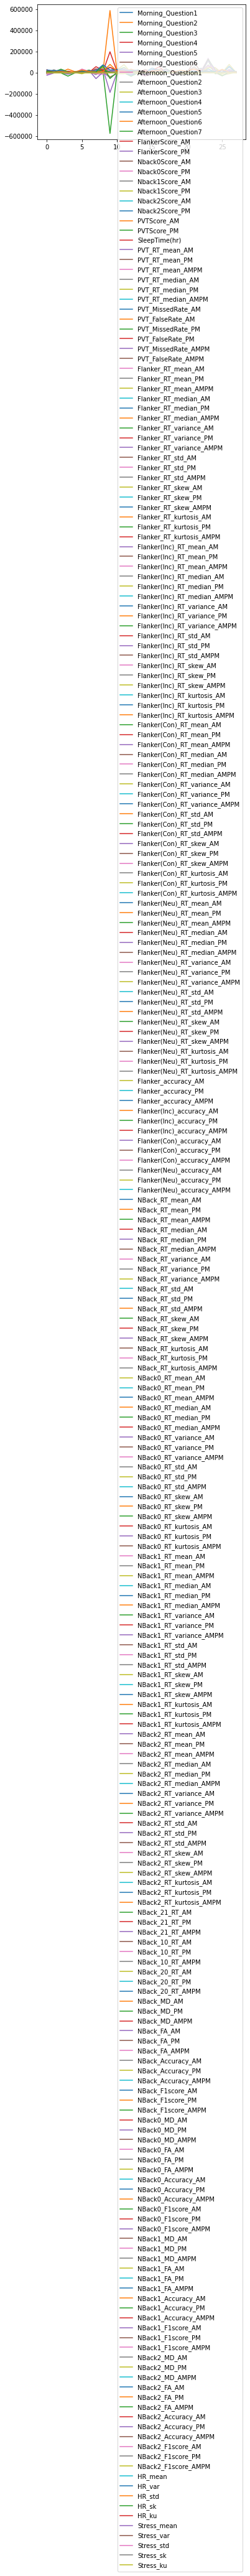

In [22]:
print("First patient, basics")
patient1.head()
patient1.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

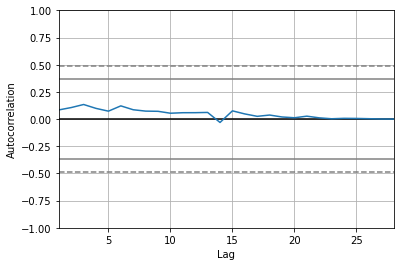

In [23]:
autocorrelation_plot(patient1)
# Must remove the date column or else this dies like this:
# mean = np.mean(data) / TypeError: can only concatenate str (not "int") to str 

# This indicates the data are slightly auto correlated to start, but then not so.

In [ ]:
dataAll = dataR + dataN
rowsR = len(dataR)
rowsN = len(dataN)
rowsAll = len(dataAll)
print("Number of patients (R,N,total):",rowsR,rowsN,rowsAll)

# Visit all patients in order.
# Either print the dates or remove the dates.
#for p in range(rowsAll):
#    patient_recs = dataAll[p]
#    #print(patient_recs['Date'])
#    patient_recs.drop(['Date'],axis=1)

We will assume timeseries records are equally spaced at one per day.
This is mostly true with a few abberations.
For example, R patient 2060_S3 is missing the record between 2020-06-01 and 2020-06-03.

We will align all patient records by measuring days-since-start.
We will ignore the specific dates which can be in different months for different patients.
Thus, we are assuming month of year has no effect on the response variable R/NR.

## Scaling and covariance
Normalize by subtracting the column mean from every column value.  
Since columns have widely different numerical ranges,   
also normalize by making each column have unit variance.  
Note: without normalization, the covariance plot would be all black except for the few features with large absolute values.

In [ ]:
# Standardize features by shifting the mean to zero and scaling to unit variance.
# Subtract the mean and divide by the std.dev: z = (x - u) / s
def scale_features(X):
    s = StandardScaler()
    z = s.fit_transform(X)
    return z
scaledMeans = scale_features(meansAll)
column_names = meansAll.columns

In [ ]:
print("Column Names:")
print(column_names)
print("Scaled Means & Variances:")
scaledMeans

In [ ]:
def plot_covariance(X):
    cv=X.T.dot(X)/len(X)
    plt.imshow(cv, cmap='hot', interpolation='nearest')
    plt.show()
plot_covariance(scaledMeans)

In [ ]:
pathR = None
pathN = None
filesR = None
filesN = None
meansR = None
meansN = None
meansAll = None